In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.applications import InceptionV3

from sklearn import preprocessing
from keras.utils import to_categorical

C:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Extraction de caractèristiques avec VGG16

In [19]:
SIZE = 222

train_images = []
train_labels = [] 

for directory_path in glob.glob('../Data/SFA_lab/Train/*'):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = []
test_labels = [] 
for directory_path in glob.glob("../Data/SFA_lab/Test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
for directory_path in glob.glob("../Data/SFA_lab/Validate/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
              
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Ecoder
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################
#Charger le modèle en mémoire sans rajouter de couches fully connected
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
    layer.trainable = False

#Extraction des caractèristiques par prédiction
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

#Même chose pour les données de test
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

Asian
Black
White
5/5 [==============================] - 35s 7s/step


# VGG16 - Random Forest

La meilleur accuracy est  0.7142857142857143  pour n_estimators =  59


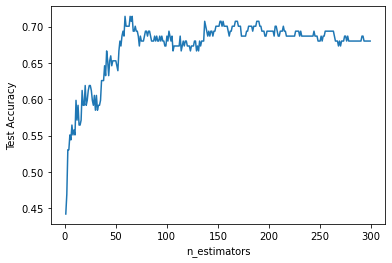

In [20]:
X_for_RF = features #This is our X input to RF
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#RANDOM FOREST
ACC = []
IDs = []
cm = 0
best = 0
bestEval = 0
for es in range(1,300):
    RF_model = RandomForestClassifier(n_estimators = es, random_state = 42)

    # Train the model on training data
    RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

    #Now predict using the trained RF model. 
    prediction_RF = RF_model.predict(X_test_features)
    #Inverse le transform to get original label back. 
    prediction_RF = le.inverse_transform(prediction_RF)
    
    a = metrics.accuracy_score(test_labels, prediction_RF)
    if(a>bestEval):
        cm = confusion_matrix(test_labels, prediction_RF)
        bestEval = a
        best = es
    ACC.append(a)
    IDs.append(es)

plt.plot(IDs,ACC)
plt.xlabel('n_estimators')
plt.ylabel('Test Accuracy')
print('La meilleur accuracy est ',bestEval,' pour n_estimators = ',best)

<AxesSubplot:>

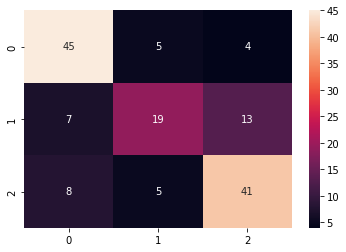

In [21]:
sns.heatmap(cm, annot=True)

# VGG16 - SVM

La meilleur accuracy est  0.7278911564625851  pour C =  9


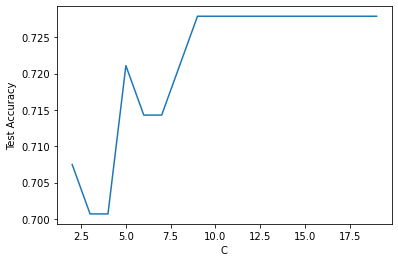

In [10]:
from sklearn.svm import SVC
X_for_SVM = features #This is our X input to RF

ACC = []
IDs = []
cm = 0
best = 0
bestEval = 0
for c in range(2,20):
# SVM
    SVM_model = SVC(C = c)

# Train the model on training data
    SVM_model.fit(X_for_SVM, y_train)

# Predict using the trained SVM model
    prediction_SVM = SVM_model.predict(X_test_features)

# Inverse transform to get original label back
    prediction_SVM = le.inverse_transform(prediction_SVM)
    
    a = metrics.accuracy_score(test_labels, prediction_SVM)
    if(a>bestEval):
        cm = confusion_matrix(test_labels, prediction_SVM)
        bestEval = a
        best = c
    ACC.append(a)
    IDs.append(c)

plt.plot(IDs,ACC)
plt.xlabel('C')
plt.ylabel('Test Accuracy')
print('La meilleur accuracy est ',bestEval,' pour C = ',best)

<AxesSubplot:>

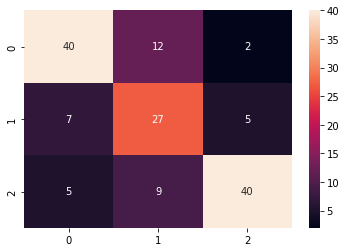

In [11]:
sns.heatmap(cm, annot=True)

# Avec InceptionV3

In [12]:
SIZE = 222

train_images = []
train_labels = [] 

for directory_path in glob.glob('../Data/SFA_lab/Train/*'):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = []
test_labels = [] 
for directory_path in glob.glob("../Data/SFA_lab/Test/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
for directory_path in glob.glob("../Data/SFA_lab/Validate/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
              
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Ecoder
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################
#Charger le modèle en mémoire sans rajouter de couches fully connected
INCEPTION_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in INCEPTION_model.layers:
    layer.trainable = False

#Extraction des caractèristiques par prédiction
feature_extractor=INCEPTION_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

#Même chose pour les données de test
X_test_feature = INCEPTION_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

Asian
Black
White
5/5 [==============================] - 9s 2s/step


# InceptionV3 - Random Forest

La meilleur accuracy est  0.6598639455782312  pour n_estimators =  185


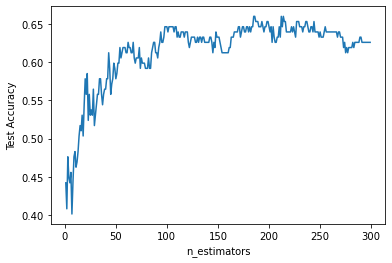

In [15]:
X_for_RF = features #This is our X input to RF
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#RANDOM FOREST
ACC = []
IDs = []
cm = 0
best = 0
bestEval = 0
for es in range(1,300):
    RF_model = RandomForestClassifier(n_estimators = es, random_state = 42)

    # Train the model on training data
    RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

    #Now predict using the trained RF model.
    prediction_RF = RF_model.predict(X_test_features)
    #Inverse le transform to get original label back. 
    prediction_RF = le.inverse_transform(prediction_RF)
    
    a = metrics.accuracy_score(test_labels, prediction_RF)
    if(a>bestEval):
        cm = confusion_matrix(test_labels, prediction_RF)
        bestEval = a
        best = es
    ACC.append(a)
    IDs.append(es)

plt.plot(IDs,ACC)
plt.xlabel('n_estimators')
plt.ylabel('Test Accuracy')
print('La meilleur accuracy est ',bestEval,' pour n_estimators = ',best)

<AxesSubplot:>

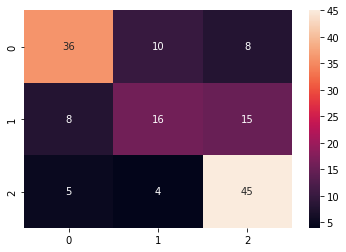

In [16]:
sns.heatmap(cm, annot=True)

# InceptionV3 - SVM

La meilleur accuracy est  0.6530612244897959  pour C =  3


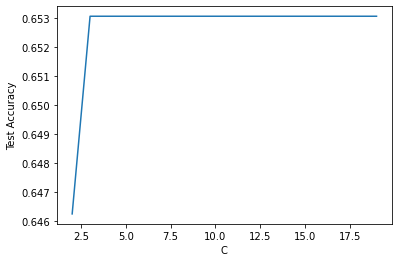

In [17]:
from sklearn.svm import SVC
X_for_SVM = features #This is our X input to RF

ACC = []
IDs = []
cm = 0
best = 0
bestEval = 0
for c in range(2,20):
# SVM
    SVM_model = SVC(C = c)

# Train the model on training data
    SVM_model.fit(X_for_SVM, y_train)

# Predict using the trained SVM model
    prediction_SVM = SVM_model.predict(X_test_features)

# Inverse transform to get original label back
    prediction_SVM = le.inverse_transform(prediction_SVM)
    
    a = metrics.accuracy_score(test_labels, prediction_SVM)
    if(a>bestEval):
        cm = confusion_matrix(test_labels, prediction_SVM)
        bestEval = a
        best = c
    ACC.append(a)
    IDs.append(c)

plt.plot(IDs,ACC)
plt.xlabel('C')
plt.ylabel('Test Accuracy')
print('La meilleur accuracy est ',bestEval,' pour C = ',best)

<AxesSubplot:>

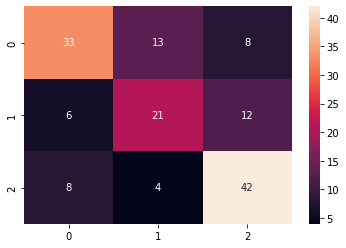

In [18]:
sns.heatmap(cm, annot=True)